In [156]:
import numpy as np
import scipy.stats
import cvxpy
import pandas as pd

import statsmodels.api as sm
import sklearn.metrics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

In [2]:
def get_sim(X):
    return np.abs(np.corrcoef(X.T))

def get_rel(X, y):
    return np.abs(np.corrcoef(X.T, y)[:-1, -1])

In [3]:
def generate_data(m, eps, seed):
    np.random.seed(seed)
    y = np.random.randn(m)
    x1 = np.random.randn(m)
    x2 = x1 + eps * y
    X = np.array([x1, x2]).T
    return X, y

In [4]:
def solve_qpfs_from_katrutsa(b, Q):
    a = cvxpy.Variable(Q.shape[1])

    problem = cvxpy.Problem(cvxpy.Maximize(b.T @ a - cvxpy.quad_form(a, Q)), [a >= 0])
    problem.solve(solver='ECOS')

    return a.value

#### Old illustration on QPFS issues in formulation from Katrutsa_2016 paper

In [36]:
m = 1000
eps = 0.001
num_attempts = 10

a_list = []

for seed in range(num_attempts):
    X, y = generate_data(m, eps, seed)

    b = get_rel(X, y)
    Q = get_sim(X)

    a = solve_qpfs_from_katrutsa(b, Q)
    a_list.append(a)
    print("SOLUTION:", a)
    
    
# SOLUTION: [1.57577192e-02 2.01086007e-08]
# SOLUTION: [1.06763521e-07 1.14062121e-02]
# SOLUTION: [6.05254637e-03 1.22225507e-06]
# SOLUTION: [1.53284022e-08 1.74994604e-02]
# SOLUTION: [1.43859131e-06 6.10161028e-03]
# SOLUTION: [2.67123647e-08 1.50881554e-02]
# SOLUTION: [3.05848931e-04 1.16792601e-06]
# SOLUTION: [1.32540008e-02 2.88693035e-08] -> look! The better feature receives smaller, infinitisemal weights
# SOLUTION: [2.65498319e-07 1.87896446e-03]
# SOLUTION: [8.83238623e-03 8.84212063e-07] -> look! The better feature receives smaller, infinitisemal weights

# Question 1: Why a_2 < a_1 in these two cases? -> think
# Question 2: What can we say in general about the results of this QPFS optimization for the dataset?

SOLUTION: [1.57577192e-02 2.01086007e-08]
SOLUTION: [1.06763521e-07 1.14062121e-02]
SOLUTION: [6.05254637e-03 1.22225507e-06]
SOLUTION: [1.53284022e-08 1.74994604e-02]
SOLUTION: [1.43859131e-06 6.10161028e-03]
SOLUTION: [2.67123647e-08 1.50881554e-02]
SOLUTION: [3.05848931e-04 1.16792601e-06]
SOLUTION: [1.32540008e-02 2.88693035e-08]
SOLUTION: [2.65498319e-07 1.87896446e-03]
SOLUTION: [8.83238623e-03 8.84212063e-07]


#### Illustration of the issues for QPFS in formulation from original paper

In [240]:
def solve_qpfs_unconstrained(b, Q, alpha=0.5, eps=None, eps_scale=2):
    a = cvxpy.Variable(Q.shape[1])
    problem = cvxpy.Problem(cvxpy.Maximize(b.T @ a - cvxpy.quad_form(a, 0.5 * Q)), [a >= 0])
    problem.solve(solver='ECOS', verbose=False, abstol=1e-10)
    a_star = a.value.copy()
    if eps is None:
        eps = 1e-20 * b.shape[0]
    while True:
        is_improved = is_fvalue_improved(b, Q, a_star, eps)
        #print("EPS / IS_IMPROVED:", eps, is_improved)
        if not is_improved:
            eps = eps / eps_scale
            break
        eps = eps * eps_scale
    
    #print("EPS:", eps)
    a_star[a_star < eps] = 0
    beta = (1 - alpha) / alpha
    return a_star / beta, a.value / beta

In [232]:
def is_fvalue_improved(b_scaled, Q_scaled, a, eps):
    def get_fvalue(b_scaled, Q_scaled, a):
        return np.sum(b_scaled * a) - 0.5 * np.dot(a, np.dot(Q_scaled, a))
    idx = (a < eps)
    if not idx.sum():
        return True
    if (not (~idx).sum()):
        return False
    cur_fvalue = get_fvalue(b_scaled, Q_scaled, a)
    a_adj = a.copy()
    a_adj[idx] = 0
    a_adj = a_adj / a_adj.sum() * a.sum()
    new_fvalue = get_fvalue(b_scaled, Q_scaled, a_adj)
    #print("DIFF:", new_fvalue - cur_fvalue)
    return (new_fvalue >= cur_fvalue)

def solve_qpfs_original(b, Q, alpha=0.5, debug=False, robust=False, eps=None, eps_scale=2):
    a = cvxpy.Variable(Q.shape[1])
    
    b_scaled = b * alpha
    Q_scaled = Q * (1 - alpha)
    
    if alpha == 1:
        if not robust:
            problem = cvxpy.Problem(cvxpy.Maximize(b_scaled.T @ a), [a >= 0, cvxpy.sum(a) == 1])
        else:
            problem = cvxpy.Problem(cvxpy.Maximize(b_scaled.T @ a), [a >= 0, cvxpy.sum(a) <= 1])
 
    else:
        if not robust:
            problem = cvxpy.Problem(cvxpy.Maximize(b_scaled.T @ a - cvxpy.quad_form(a, 0.5 * Q_scaled)), [a >= 0, cvxpy.sum(a) == 1])
        else:
            problem = cvxpy.Problem(cvxpy.Maximize(b_scaled.T @ a - cvxpy.quad_form(a, 0.5 * Q_scaled)), [a >= 0, cvxpy.sum(a) <= 1])

    problem.solve(solver='ECOS', verbose=False, abstol=1e-10)

    a_star = a.value.copy()
    #print(a.value)
    if eps is None:
        eps = 1e-20 * b.shape[0]
    while True:
        is_improved = is_fvalue_improved(b_scaled, Q_scaled, a_star, eps)
        #print("EPS / IS_IMPROVED:", eps, is_improved)
        if not is_improved:
            eps = eps / eps_scale
            break
        eps = eps * eps_scale
    
    #print("EPS:", eps)
    a_star[a_star < eps] = 0
    a_star = a_star / (1e-20 + a_star.sum())
    return a_star, a.value

In [6]:
# This function generates a dataset with several noise features (irrelevant) 
# and target variable being the difference of another two features after proper scaling

def generate_data_with_diff_and_noise(m, eps, num_noise, seed):
    np.random.seed(seed)
    y = np.random.randn(m)
    x1 = np.random.randn(m)
    x2 = x1 + eps * y
    X = np.array([x1, x2]).T
    X_noise = np.random.randn(m, num_noise)
    return np.concatenate((X, X_noise), axis=1), y

In [137]:
def analyze_solution(a):
    num_active_noise = (a[2:] > 0).sum()
    is_active_first = int(a[0] > 0)
    is_active_second = int(a[1] > 0)
    num_noises_greater_than_second = (a[2:] > a[1]).sum()
    return is_active_first, is_active_second, num_active_noise, num_noises_greater_than_second

In [234]:
%%time
m = 10000
eps = 0.01
num_noise = 10
robust = False # when set to True we solve for ||a||_1 <= beta
# Setting it as an equality constraint, actually starts to act in a weird way for beta = alpha / (1 - alpha) > ||b||_1
# If ||a||_1 is forced to be big (e.g. alpha=1), the maximum of b^T a is achieved for degenerate solution 
# putting everything in a single feature with biggest similarity.
# This is actually the reversal of what is happening when the inequality constraint is still tight.

solution_info_df = pd.DataFrame(dtype=float, columns=["alpha", "seed", "is_active1", "is_active2", "num_active_noises", "num_better_noises"])
idx = 0

alpha_list = [0] + list(np.logspace(-6, -2, 5)) + list(np.linspace(0.015, 0.985, 98)) + \
list(1. - np.logspace(-6, -2, 9)[::-1]) + [1]

seed = 11
X, y = generate_data_with_diff_and_noise(m, eps, num_noise, seed)

for seed in range(10):
    b = get_rel(X, y)
    Q = get_sim(X)

    for alpha in alpha_list:
        try:
            cur_a, _ = solve_qpfs_original(b, Q, alpha, robust=robust)
            solution_info_df.loc[idx] = [alpha, seed] + list(analyze_solution(cur_a))
        except:
            print(f"ISSUE WITH ALPHA={alpha}, seed={seed}")
        idx += 1

CPU times: user 21.8 s, sys: 112 ms, total: 21.9 s
Wall time: 29 s


In [217]:
avg_solution_df = solution_info_df.groupby("alpha").mean().loc[:, ["is_active1", "is_active2",\
                                                                   "num_active_noises", "num_better_noises"]]

In [248]:
avg_solution_df

,is_active1,is_active2,num_active_noises,num_better_noises
alpha,,,,
0.000000,0.0,1.0,10.0,6.0
0.000001,0.0,1.0,10.0,6.0
0.000010,0.0,1.0,10.0,6.0
0.000100,0.0,1.0,10.0,6.0
0.001000,0.0,1.0,10.0,6.0
0.010000,0.0,1.0,10.0,6.0
0.015000,0.0,1.0,10.0,6.0
0.025000,0.0,1.0,10.0,5.0
0.035000,0.0,1.0,10.0,5.0


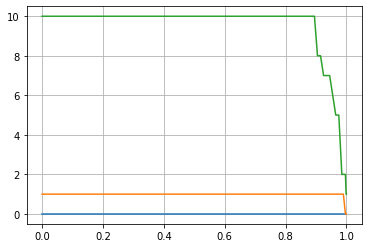

In [253]:
plot(alpha_list, avg_solution_df["is_active1"]) # first feature is never active
plot(alpha_list, avg_solution_df["is_active2"]) 
# second feature is active until alpha=0.99, 
# when 2 out of 10 noises remain active and have higher weight than 2nd feature
plot(alpha_list, avg_solution_df["num_active_noises"]) # all 10 noises remain active until alpha=0.895 
# (2 have higher a* than the second feature that is in reality relevant to y)
# In the end remain just one feature, and the feature is the noise one!
plt.grid()

In [241]:
solve_qpfs_unconstrained(b, Q) # even unconstrained solution has 0 weight on first feature

(array([0.        , 0.01603855, 0.        , 0.01996452, 0.00850171,
        0.01294355, 0.        , 0.01236458, 0.01138127, 0.00248603,
        0.00706283, 0.01850955]),
 array([4.10874765e-12, 1.60385463e-02, 3.96982478e-10, 1.99645185e-02,
        8.50171267e-03, 1.29435519e-02, 6.18490556e-11, 1.23645795e-02,
        1.13812674e-02, 2.48603341e-03, 7.06282540e-03, 1.85095527e-02]))

#### Multicollinearity illustration

In [423]:
np.random.seed(123)
n = 10
m = 1000

eps = 0.001 # illustrates strong multicollinearity. Yet when keeping all features we do better in testing sample.
# The higher condition number did not result in deterioration in performance.
eps = 1 # illustrates potential benefits from keeping more features (there is less multicollinearity here though)

y = np.random.randn(m)
X = eps * np.random.randn(m, n) + y[:, None]

In [424]:
m_test = 10000
y_test = np.random.randn(m_test)
X_test = eps * np.random.randn(m_test, n) + y_test[:, None]

In [425]:
linear_regr = sm.OLS(y, X)
linear_regr = linear_regr.fit()

linear_regr_one = sm.OLS(y, X[:, :1])
linear_regr_one = linear_regr_one.fit()

In [426]:
y_test_predicted = linear_regr.predict(X_test)
y_test_predicted_one = linear_regr_one.predict(X_test[:, :1])

r2_all = sklearn.metrics.r2_score(y_test, y_test_predicted)
r2_one = sklearn.metrics.r2_score(y_test, y_test_predicted_one)

print("R2, %:", [np.round(item, 7) for item in [100 * r2_all, 100 * r2_one]])
print("R2 gap to 100%, %:", [np.round(100 - item, 7) for item in [100 * r2_all, 100 * r2_one]])

#99.90153840975476 98.99507045582031
#0.09846159024523615 1.0049295441796886

R2, %: [91.1018374, 49.6988733]
R2 gap to 100%, %: [8.8981626, 50.3011267]


In [427]:
print(linear_regr.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              953.4
Date:                Wed, 31 Mar 2021   Prob (F-statistic):                        0.00
Time:                        16:01:48   Log-Likelihood:                         -238.64
No. Observations:                1000   AIC:                                      497.3
Df Residuals:                     990   BIC:                                      546.4
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

From the above, multicollinearity is strong (condition number is 3.47e3)
Yet, there is no issue in estimation, and we do get better R2 with 10 features vs 1.
We are already close to 100% R2, so the gain does not appear that big.
Yet, the same is pronounced for higher eps, which would mean lower R2 for a single feature.